In [1]:
from IPython.display import display, Math, HTML, Image
import orbits

display(HTML("<h1>NGC 6397</h1>"))
# display(Image(url='https://upload.wikimedia.org/wikipedia/commons/9/99/P0321a.jpg', width=1024))

display(Math('\\text{{RA}} = {}^{{\\circ}}'.format(orbits.RA)))
display(Math('\\text{{DEC}} = {}^{{\\circ}}'.format(orbits.DEC)))
display(Math('\\mu_\\alpha \\cos\\delta = {} \\pm {}^{{\\circ}}'.format(*orbits.PMRA)))
display(Math('\\delta = {} \\pm {}^{{\\circ}}'.format(*orbits.PMDEC)))
display(Math('R_\\odot = {}\\text{{ kpc}}'.format(orbits.RSUN)))
display(Math('\\sigma = {}\\text{{ mas/yr}}'.format(orbits.SIGMA)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [2]:
import gaia
import numpy as np

display(Math('N_\\text{{initial}} = {}'.format(len(gaia.data))))

<IPython.core.display.Math object>

In [3]:

# Clean out bad data
cut = gaia.data['bp_rp'] != 0

display(HTML('Cleaning for zero BP-RP'))
display(Math('N_\\text{{clean}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

In [4]:

# Perform a proper motion cut
cut &= np.abs(gaia.data['pmra'] - orbits.PMRA[0]) < (2 * gaia.data['pmra_error'])
cut &= np.abs(gaia.data['pmdec'] - orbits.PMDEC[0]) < (2 * gaia.data['pmdec_error'])


display(HTML('Proper motion cut'))
display(Math('\\mu_\\alpha \\cos\\delta_i - \\mu_\\alpha \\cos\\delta < 2 \\epsilon_{{\\mu_\\alpha \\cos\\delta_i}}'))
display(Math('\\mu_{\\delta_i }- \\mu_{\\delta} < 2 \\epsilon_{{\\mu_{\\delta_i}}}'))
display(Math('N_\\text{{pm}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:

# Perform a statistical selection
chi2 = 5
cut &= (gaia.data['pmra'] - orbits.PMRA[0])**2 / (orbits.SIGMA**2 + gaia.data['pmra_error']**2) + \
       (gaia.data['pmdec'] - orbits.PMDEC[0])**2 / (orbits.SIGMA**2 + gaia.data['pmdec_error']**2) <= chi2


display(HTML('Statistical criterion cut'))
display(Math('''\\chi^2 = \\frac{(\\mu_\\alpha \\cos\\delta_i - \\mu_\\alpha \\cos\\delta)^2}{(\\sigma^2 + \\epsilon_{{\\mu_\\alpha \\cos\\delta_i}})^2} + \\
                \\frac{(\\mu_{\\delta_i} - \\mu_{\\delta_i})^2}{(\\sigma^2 + \\epsilon_{{\\mu_{\\delta_i}}})^2} \\le 5''')) 
display(Math('N_{{\\chi^2}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:

# Perform a colour-magnitude cut
from scipy import stats
from geom import angular_dist, deg2rad

# Seperate the cluster into inside 0.5 degree radius and outside.
distances = angular_dist(gaia.data, orbits.RA, orbits.DEC)
inside = distances < deg2rad(0.5)

# Find all of the faint stars (mag > 20.1) 
faint = gaia.data['phot_g_mean_mag'] > 20.1

# Of the stars outside the 0.5 deg radius, determine if
# the angular separation is of the same distribution.
g1 = cut & ~inside & faint
g2 = cut & ~inside & ~faint
result = stats.kstest(distances[g1], distances[g2])

# If reasonably certain the two groups are different,
# throw away the faint ones.
if result.pvalue < 0.05:
    cut &= ~g1


display(HTML('Final selection'))
display(Math('N_\\text{{final}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

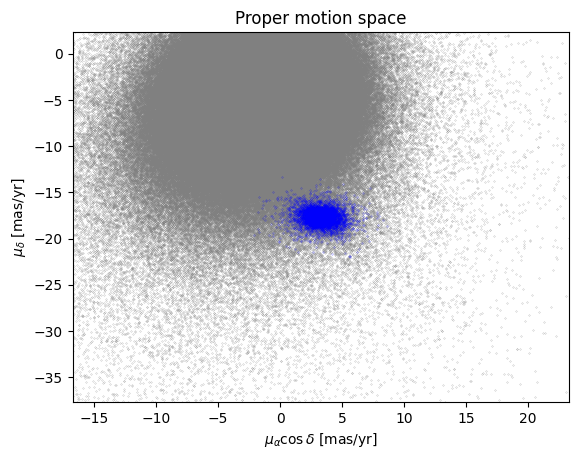

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Draw a proper motion diagram.
fig, ax = plt.subplots(ncols=1)

ax.set(
    title=r'Proper motion space',
    xlim=[orbits.PMRA[0]-20, orbits.PMRA[0]+20],
    ylim=[orbits.PMDEC[0]-20, orbits.PMDEC[0]+20]
)
ax.set_xlabel(r'$\mu_{\alpha} \cos \delta$ [mas/yr]')
ax.set_ylabel(r'$\mu_{\delta}$ [mas/yr]')

# Stars outside the proper motion space
ax.scatter(gaia.data['pmra'][~cut], gaia.data['pmdec'][~cut], color='gray', s=0.1, marker='.')

# Stars inside the proper motion space
ax.scatter(gaia.data['pmra'][cut], gaia.data['pmdec'][cut], color='b', s=0.1, marker='.')


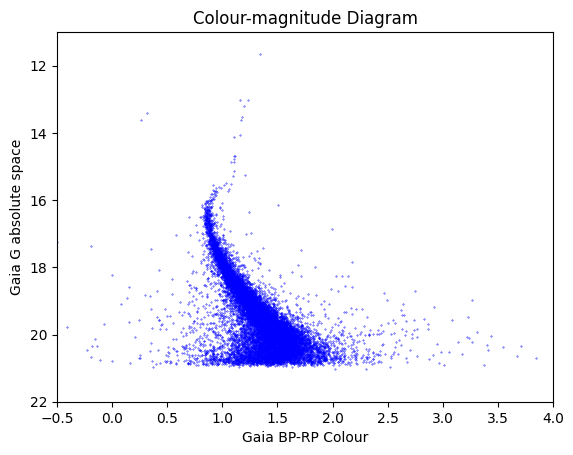

In [8]:
# Draw a colour-magnitude diagram

fig, ax = plt.subplots(ncols=1)
ax.invert_yaxis()
ax.set_xlabel('Gaia BP-RP Colour')
ax.set_ylabel('Gaia G absolute space')
ax.set(
    title=r'Colour-magnitude Diagram',
    xlim=[-0.5, 4.0],
    ylim=[22, 11]
)

#ax.scatter(gaia.data['bp_rp'][~cut], gaia.data['phot_g_mean_mag'][~cut], color='gray', marker='x', s=0.1)
ax.scatter(gaia.data['bp_rp'][cut], gaia.data['phot_g_mean_mag'][cut], color='b', s=0.1)


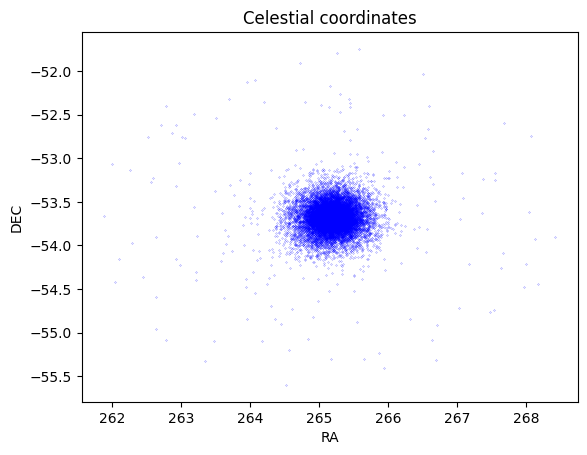

In [9]:

# Plot the spatial coordinates
fig, ax = plt.subplots(ncols=1)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Celestial coordinates')
ax.scatter(gaia.data['ra'][cut], gaia.data['dec'][cut], color='b', marker='.', s=0.1)


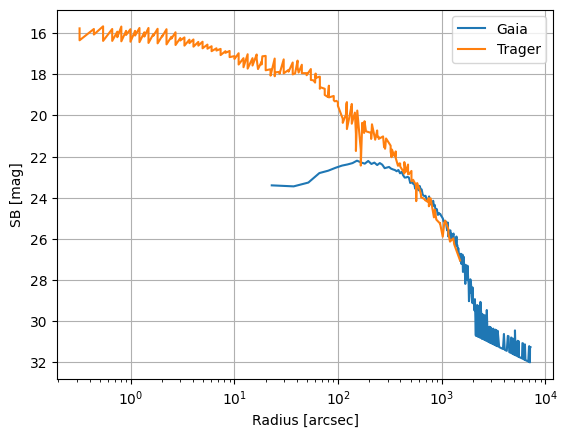

In [10]:

# Stitch with Trager et al.
from geom import rad2arcsec
trager = np.loadtxt('ngc6397_trager.dat')
arcsec_distance = rad2arcsec(angular_dist(gaia.data[cut], orbits.RA, orbits.DEC))

counts, bins = np.histogram(arcsec_distance, bins=500)

fig, ax = plt.subplots(ncols=1)

ax.set_xlabel(r'Radius [arcsec]')
ax.set_ylabel(r'SB [mag]')
ax.set_xscale("log")
ax.grid()
ax.invert_yaxis()
# ax.set(title="Surface Density")

# Divide the sum in each bin by the area of the annulus
r_b = bins[:-1]
dr_b = bins[1] - bins[0]
area = 2 * np.pi * r_b * dr_b

ax.plot(r_b[counts > 0], (-2.5) * np.log10((1e-7 * counts / area)[counts > 0]), label='Gaia')
ax.plot(10**trager[:,0], trager[:,1], label='Trager')
ax.legend()